# 预训练模型

conlstm.py文件中，使用的是encode - decoder结构，两者虽然都同样使用了convlstm，但是因为参数不共享，长程预测效果并不好。  
同时，训练也有问题。我使用最后一个输出状态（类似文本分类后的 特征编码），与目标图片计算loss并反向传播。

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from npy: 850it [00:00, 13512.73it/s]


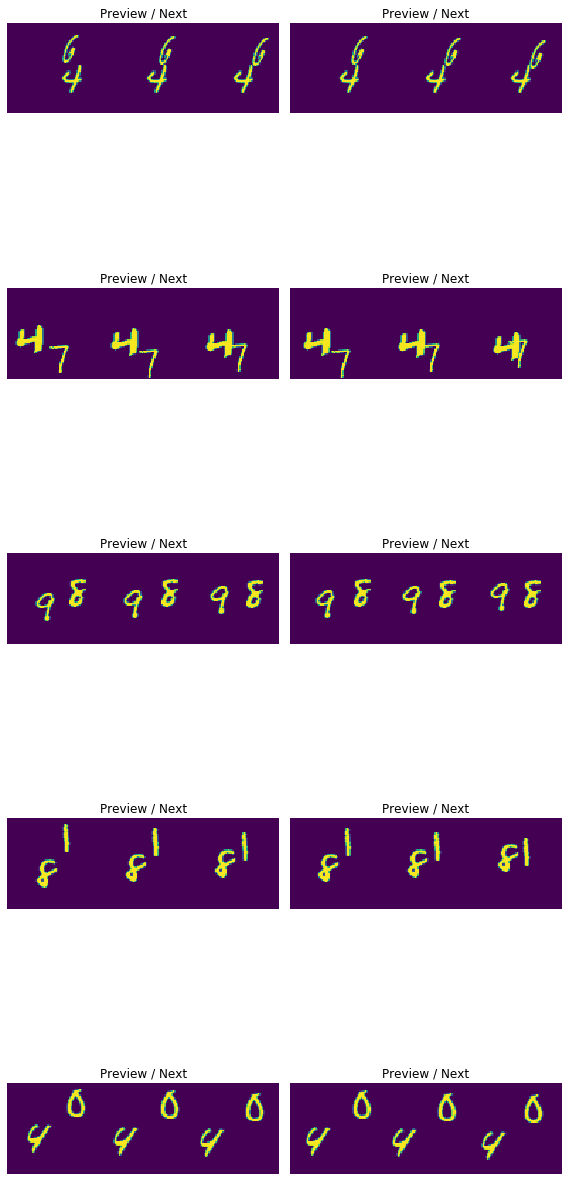

In [7]:
import json
from torch.utils.data._utils.collate import default_collate
from tqdm import tqdm
import random
from pprint import pprint
import os
from itertools import chain
import collections
from typing import List, Dict, Tuple
import logging
from collections import Iterable
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
from fastai import *
from fastai.vision import *


class ConsImage(ItemBase):
    def __init__(self, imgs_x: List[Image], imgs_y: List[Image]):
        assert isinstance(imgs_x[0], Image)
        self.imgs_x = imgs_x
        self.imgs_y = imgs_y

    def apply_tfms(self, tfms:Collection, **kwargs):
        for img in chain(self.imgs_x, self.imgs_y):
            img.apply_tfms(tfms, **kwargs)

    def show(self, ax:plt.Axes, **kwargs):
        raise NotImplemented
    def __str__(self):
        return f"{len(self.imgs_x)} {len(self.imgs_y)}"

def generate(data: Tensor, winsize):
    assert winsize <= data.shape[0]
    for d in data.permute(1,0,2,3):
        assert len(d.shape) == 3
        for i in range(d.shape[0] - winsize + 1):
            yield d[i: i + winsize - 1, :, :,], d[i+1: i + winsize, :, :] # 错位

class TMPImageList(ItemList):
    def reconstruct(self, t:Tensor, x:Tensor=None):
        return Image(torch.cat([w for w in t], -1).unsqueeze(0))

class MyImageList(ItemList):
    _bunch = DataBunch
    _label_cls = TMPImageList

    @classmethod
    def from_npy(cls, file: Path, winsize = 4, normalize = False):
        # create ItemList, which contains objects we want
        data = np.load(file)
        if normalize: data = data/255
        if not isinstance(data, Tensor):
            data = torch.from_numpy(data)
        assert len(data.shape) == 4 # some tensor like: 20, 50, 64, 64
        items = []
        for x, y in tqdm(generate(data, winsize), desc="from npy"):
            x = [Image(w.unsqueeze(0)) for w in x]
            y = [Image(w.unsqueeze(0)) for w in y]
            items.append(ConsImage(x, y))
        res = cls(items)
        return res

    def reconstruct(self, t:Tensor, x:Tensor=None):
        return Image(torch.cat([w for w in t], -1).unsqueeze(0))

    # def get(self, i)->Any:
    #     "Subclass if you want to customize how to create item `i` from `self.items`."
    #     return self.items[i]
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = len(xs)

        axs = subplots(rows, 2, imgsize=imgsize, figsize=figsize)
        for i in range(0, len(axs.flatten()),  2):
            ax = axs.flatten()[i]
            index = i // 2
            x = xs[index]
            y = ys[index]
            x.show(ax = ax, **kwargs)
            y.show(ax = axs.flatten()[i+1], **kwargs)
#         for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)

def label_func(input):
    # print(type(x))
    # print(x)
    return input.imgs_y

def collate(samples):
    x, y = zip(*samples)
    tensor_x = torch.stack([torch.cat([w.data for w in c.imgs_x]) for c in x])
    tensor_y = torch.stack([torch.cat([w.data for w in c.imgs_y]) for c in x])
    assert len(tensor_x.shape) == len(tensor_y.shape) == 4
    return tensor_x, tensor_y

BATCHSIZE = 32
WINSIZE = 4

data_pth = Path('./data_samples.npy')
data = MyImageList.from_npy(data_pth, winsize=WINSIZE) # construct MyImageList which contains itembase
data = data.split_by_rand_pct(0.15) # ItemLists which contains trains and valids
data = data.label_from_func(label_func)
data = data.databunch(bs = BATCHSIZE, collate_fn = collate, num_workers = 0) # to debug, we set

data.show_batch(title = "Preview / Next")

In [8]:
from convlstm import *
def get_model():
    encoder = ConvLSTM(input_size=(64, 64),
                 input_dim=1,
                 hidden_dim=[64, 64, 1],
                 kernel_size=(3, 3),
                 num_layers=3,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)

    model = Encorder(encoder)
    return model

def loss_func(x, y):
    assert x.shape == y.shape
    x = x.view(-1).float()
    y = y.view(-1).float()
    assert len(x) == len(y), f'{len(x)} {len(y)}'
    return F.mse_loss(x, y)

model = get_model()
learner = Learner(data, model, loss_func = loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 5.25E-02


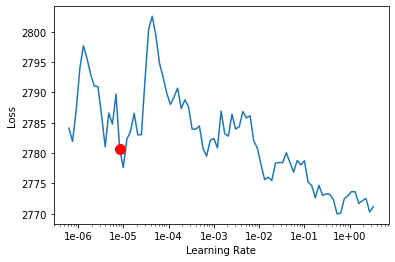

In [4]:
learner.lr_find();learner.recorder.plot(suggestion = True)

In [5]:
learner.fit_one_cycle(10, 1e-5)

epoch,train_loss,valid_loss,time
0,2790.252197,2836.832031,00:04
1,2789.491699,2836.653564,00:07
2,2786.935547,2836.315186,00:08
3,2786.159668,2835.931885,00:08
4,2785.360840,2835.564453,00:09
5,2786.713135,2835.250000,00:11
6,2788.476074,2835.022705,00:15
7,2787.480469,2834.889648,00:15
8,2788.156494,2834.837402,00:15
9,2789.851318,2834.829346,00:16


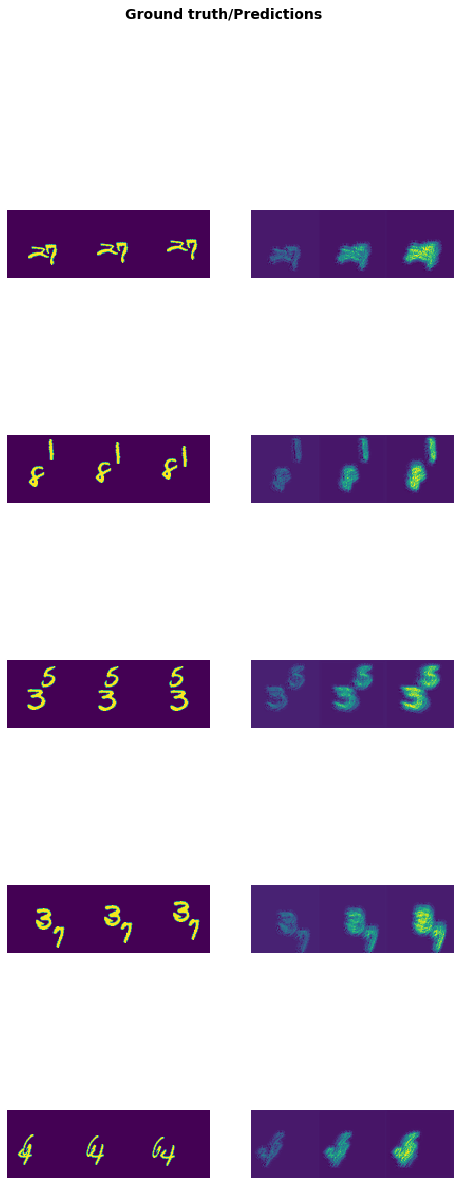

In [6]:
learner.show_results()

根本就不收敛。。。

from npy: 850it [00:00, 13479.17it/s]


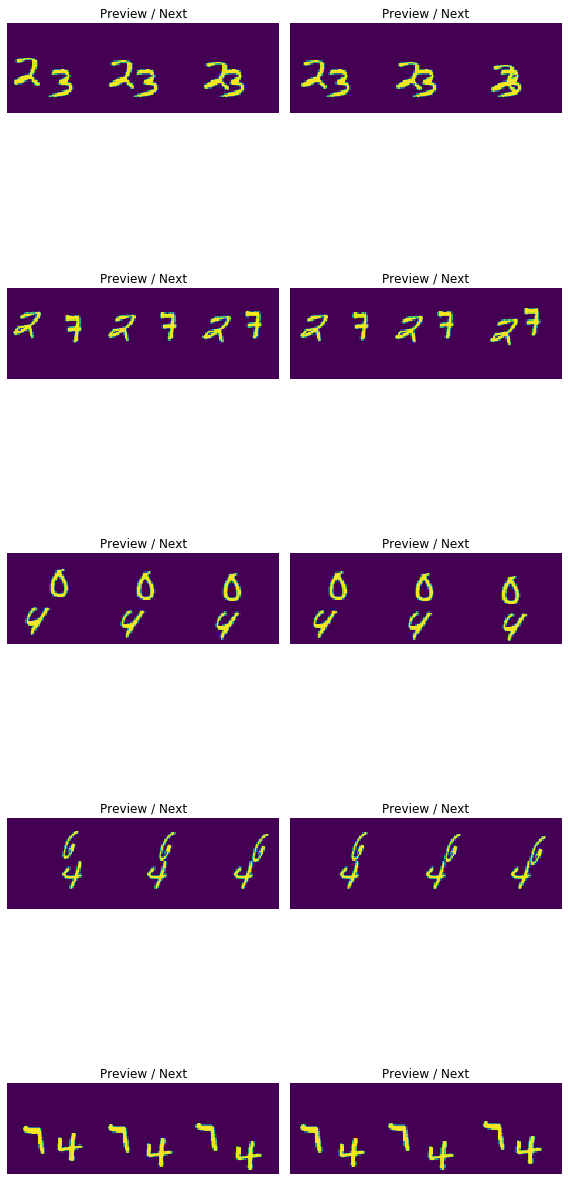

In [9]:
data_pth = Path('./data_samples.npy')
data = MyImageList.from_npy(data_pth, winsize=WINSIZE, normalize=True) # 归一化
data = data.split_by_rand_pct(0.15) # ItemLists which contains trains and valids
data = data.label_from_func(label_func)
data = data.databunch(bs = BATCHSIZE, collate_fn = collate, num_workers = 0) # to debug, we set

data.show_batch(title = "Preview / Next")

In [17]:
data.train_ds[0][0].imgs_x[0].data.max() # 最大值变成了1

tensor(1., dtype=torch.float64)

In [18]:
model = get_model()
learner = Learner(data, model, loss_func = loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 3.31E-03


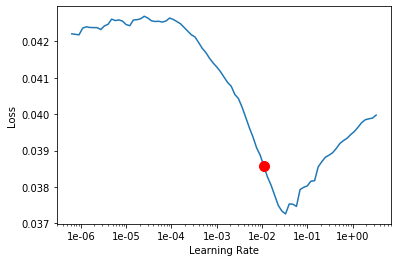

In [19]:
learner.lr_find();learner.recorder.plot(suggestion = True)

In [20]:
learner.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.036359,0.027846,00:15
1,0.030762,0.024068,00:12
2,0.028151,0.023589,00:14
3,0.026516,0.022302,00:10
4,0.024875,0.021108,00:09
5,0.023671,0.020717,00:12
6,0.022828,0.020578,00:20
7,0.022250,0.020397,00:20
8,0.021828,0.020327,00:21
9,0.021532,0.020314,00:23


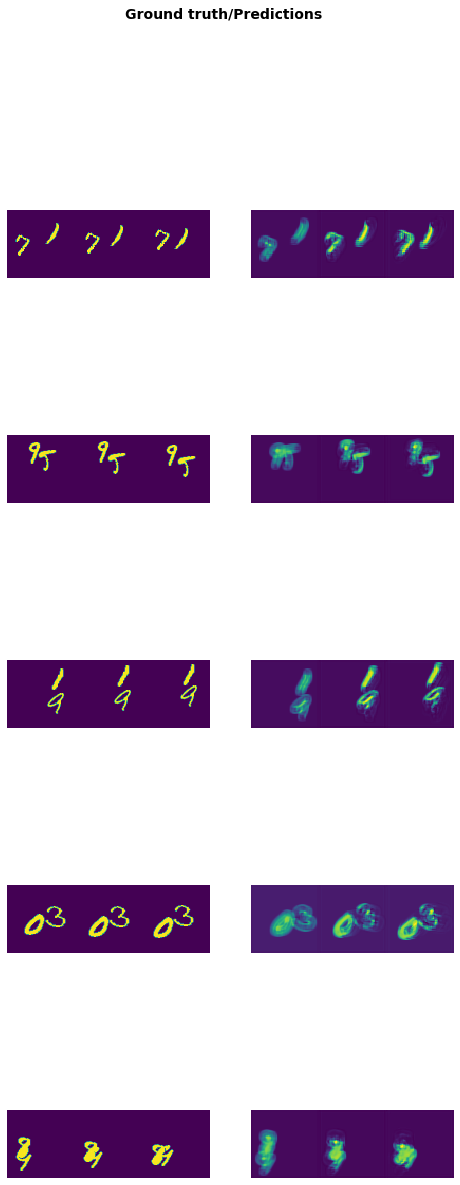

In [21]:
learner.show_results()

In [78]:
def loss_func(x, y):
    assert x.shape == y.shape
    x = x.view(-1).float()
    y = y.view(-1).float()
    assert len(x) == len(y), f'{len(x)} {len(y)}'
    return F.l1_loss(x, y)
def get_model():
    encoder = ConvLSTM(input_size=(64, 64),
                 input_dim=1,
                 hidden_dim=[64, 32, 16, 8, 4, 1],
                 kernel_size=(3, 3),
                 num_layers=6,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)

    model = Encorder(encoder)
    return model
# optar = partial(Ranger)
model = get_model()
learner = Learner(data, model, loss_func = loss_func)

In [79]:
learner.summary()

Encorder
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [256, 64, 64]        150,016    True      
______________________________________________________________________
Conv2d               [128, 64, 64]        110,720    True      
______________________________________________________________________
Conv2d               [64, 64, 64]         27,712     True      
______________________________________________________________________
Conv2d               [32, 64, 64]         6,944      True      
______________________________________________________________________
Conv2d               [16, 64, 64]         1,744      True      
______________________________________________________________________
Conv2d               [4, 64, 64]          184        True      
______________________________________________________________________

Total params: 297,320
Total trainable params: 297,320
Total non-trainable params: 0
Optimized with 'torch.optim.adam

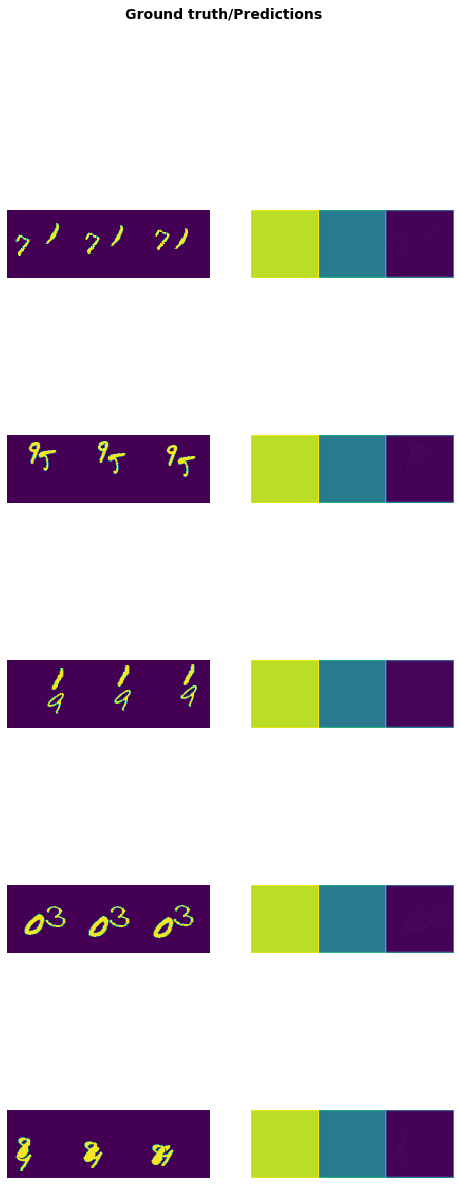

In [80]:
learner.show_results()

In [81]:
class Show_Image(LearnerCallback):
        def on_epoch_end(self, **kwargs:Any)->None:
            self.learn.show_results(rows=1)

In [82]:
learner.callbacks.append(Show_Image(learner))

epoch,train_loss,valid_loss,time
0,0.050138,0.049688,00:07
1,0.050266,0.049570,00:06
2,0.050232,0.050006,00:06
3,0.050251,0.049758,00:06
4,0.050199,0.049535,00:06


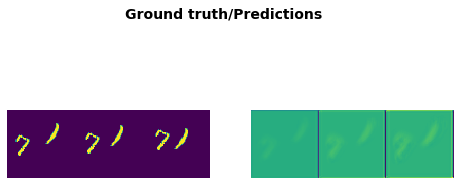

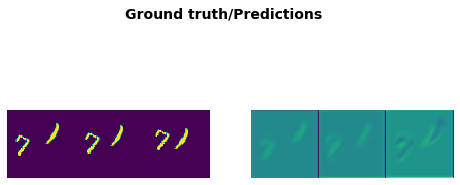

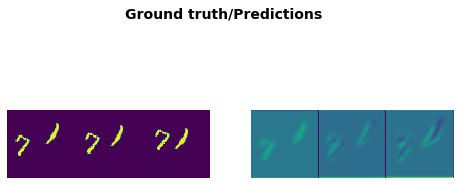

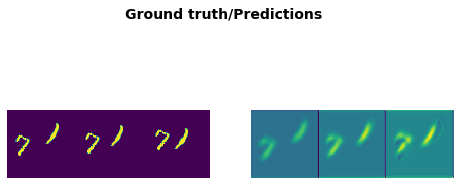

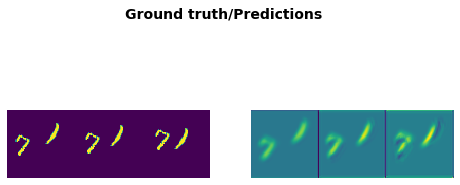

In [84]:
learner.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.050154,0.049543,00:06
1,0.050400,0.049929,00:05
2,0.049588,0.043975,00:07
3,0.047166,0.041289,00:06
4,0.045232,0.040882,00:06


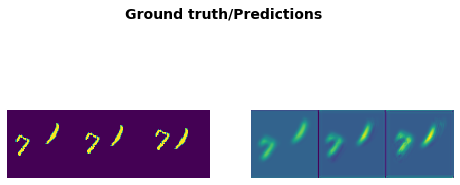

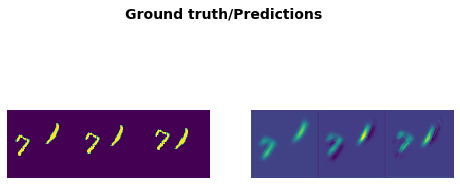

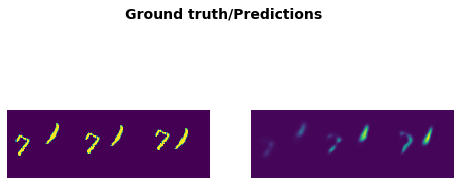

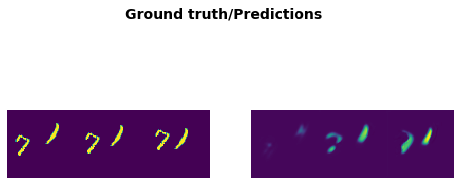

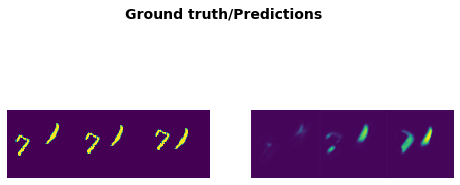

In [85]:
learner.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.042159,0.040492,00:06
1,0.042233,0.039761,00:05
2,0.042170,0.040215,00:05
3,0.041406,0.038908,00:05
4,0.040677,0.038160,00:06
5,0.039903,0.037273,00:05
6,0.039207,0.036709,00:06
7,0.038626,0.036509,00:04
8,0.038123,0.036299,00:05
9,0.037725,0.036273,00:05


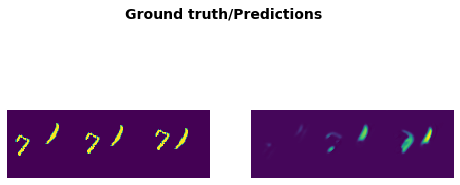

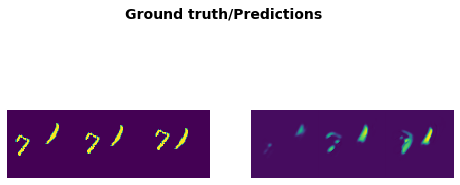

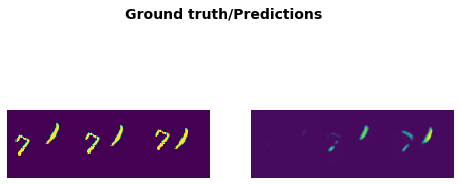

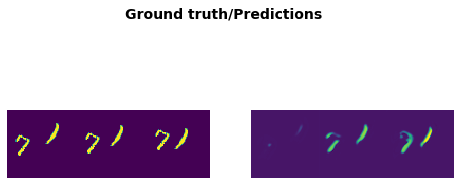

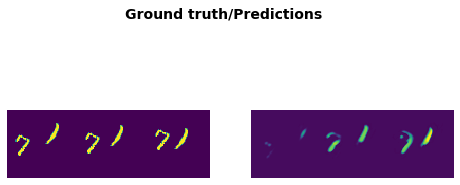

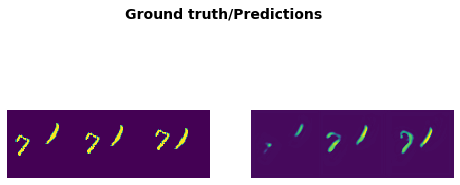

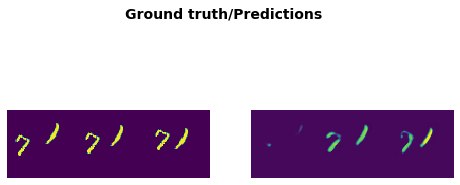

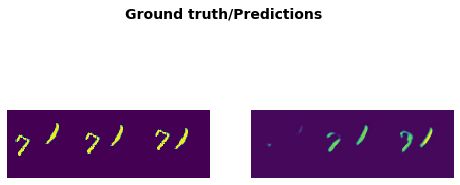

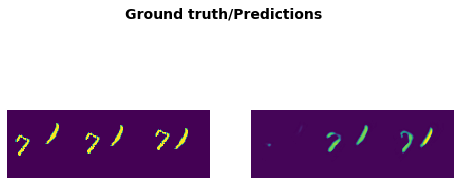

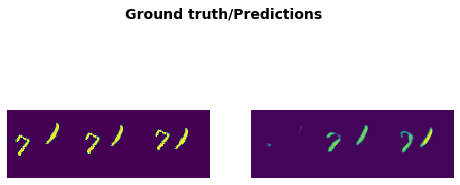

In [86]:
learner.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.037009,0.036267,00:03
1,0.037046,0.036614,00:03
2,0.037208,0.036403,00:04
3,0.037202,0.036819,00:07
4,0.037018,0.036064,00:05
5,0.036693,0.035462,00:11
6,0.036316,0.035329,00:10
7,0.035940,0.035127,00:11
8,0.035607,0.035015,00:10
9,0.035328,0.034961,00:10


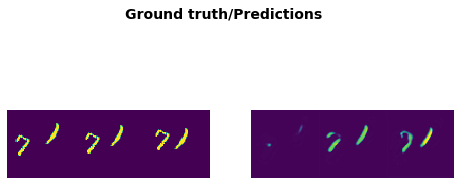

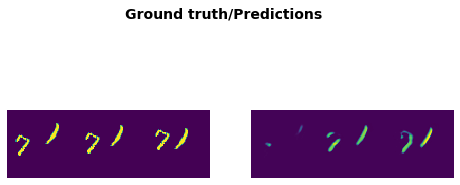

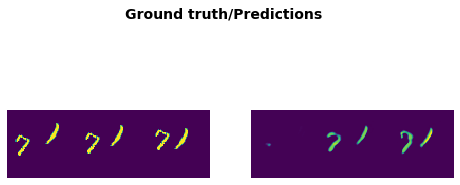

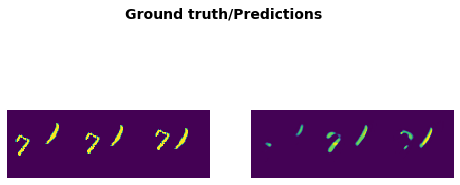

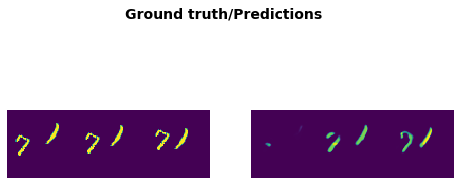

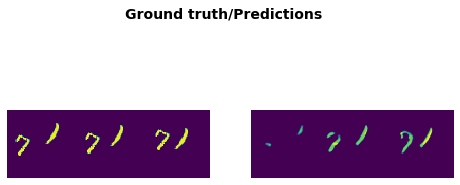

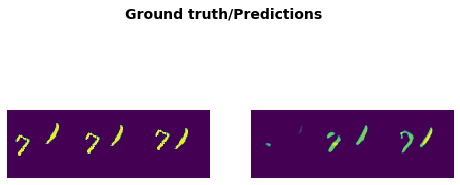

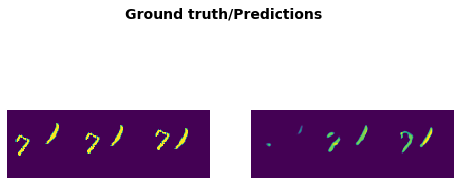

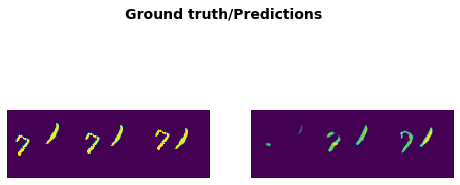

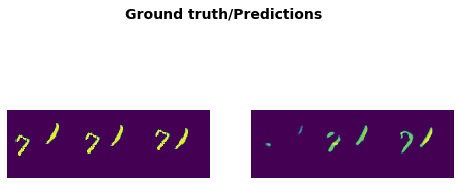

In [87]:
learner.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.034858,0.034941,00:11
1,0.034812,0.034948,00:11
2,0.034758,0.034921,00:12
3,0.034682,0.034820,00:15
4,0.034627,0.034793,00:18
5,0.034526,0.034763,00:19
6,0.034439,0.034756,00:20
7,0.034359,0.034775,00:20
8,0.034329,0.034741,00:20
9,0.034288,0.034677,00:20


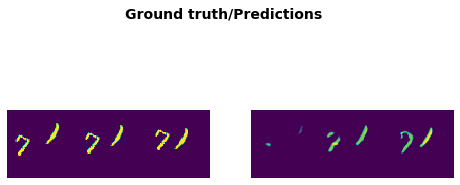

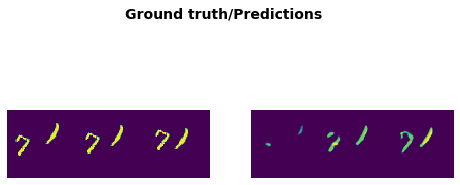

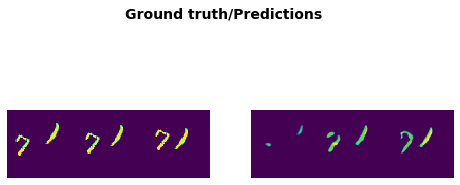

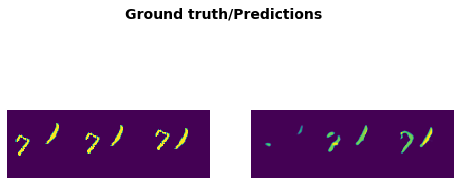

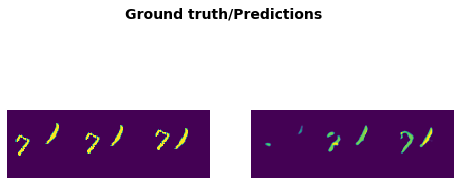

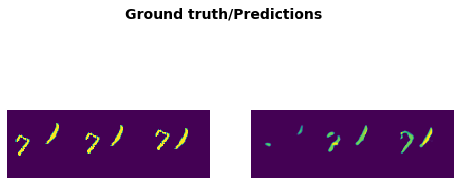

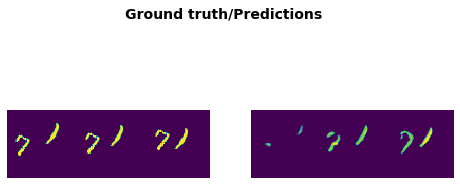

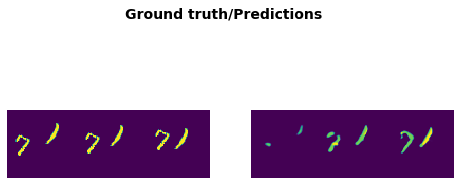

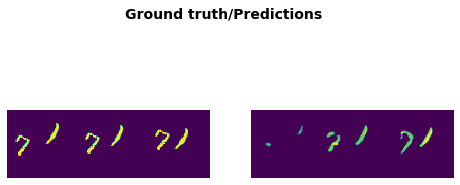

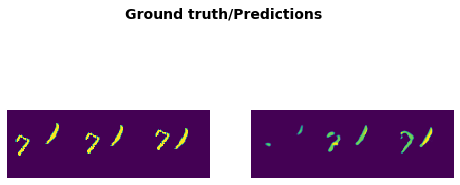

In [88]:
learner.fit(10, 1e-3)

In [89]:
WINSIZE = 10
data_pth = Path('./mnist_test_seq.npy')
data = MyImageList.from_npy(data_pth, winsize=WINSIZE) # construct MyImageList which contains itembase
data = data.split_by_rand_pct(0.15) # ItemLists which contains trains and valids
data = data.label_from_func(label_func)
data = data.databunch(bs = BATCHSIZE, collate_fn = collate) # to debug, we set
model = get_model()
learner = Learner(data, model, loss_func = loss_func)

from npy: 110000it [00:23, 4699.59it/s]


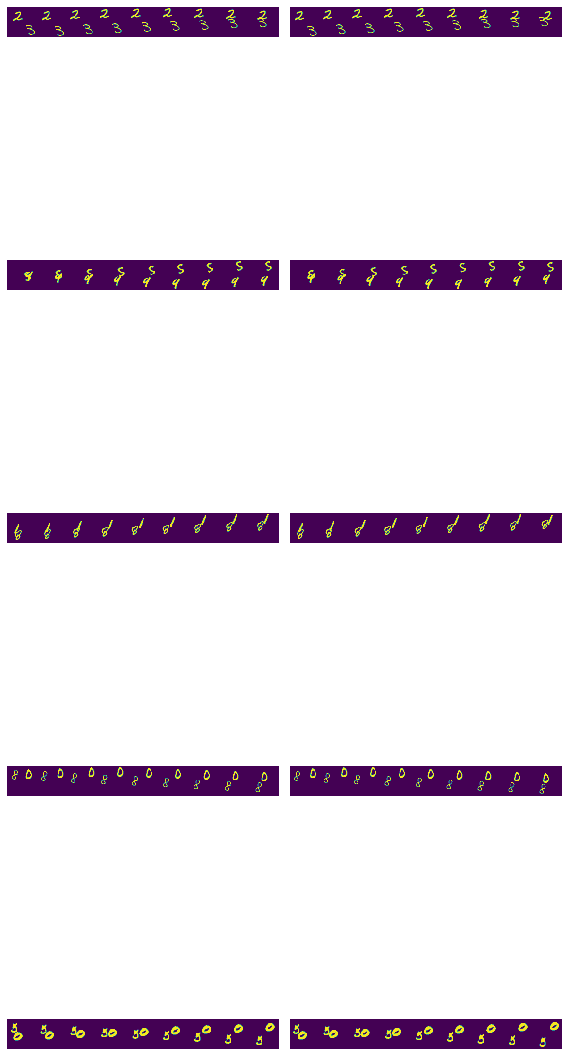

In [90]:
data.show_batch()

In [91]:
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,12.564814,12.534479,2:49:00


In [92]:
learner.save('st2')

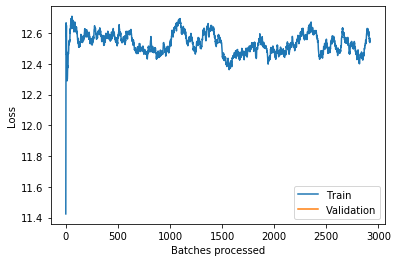

In [93]:
learner.recorder.plot_losses()

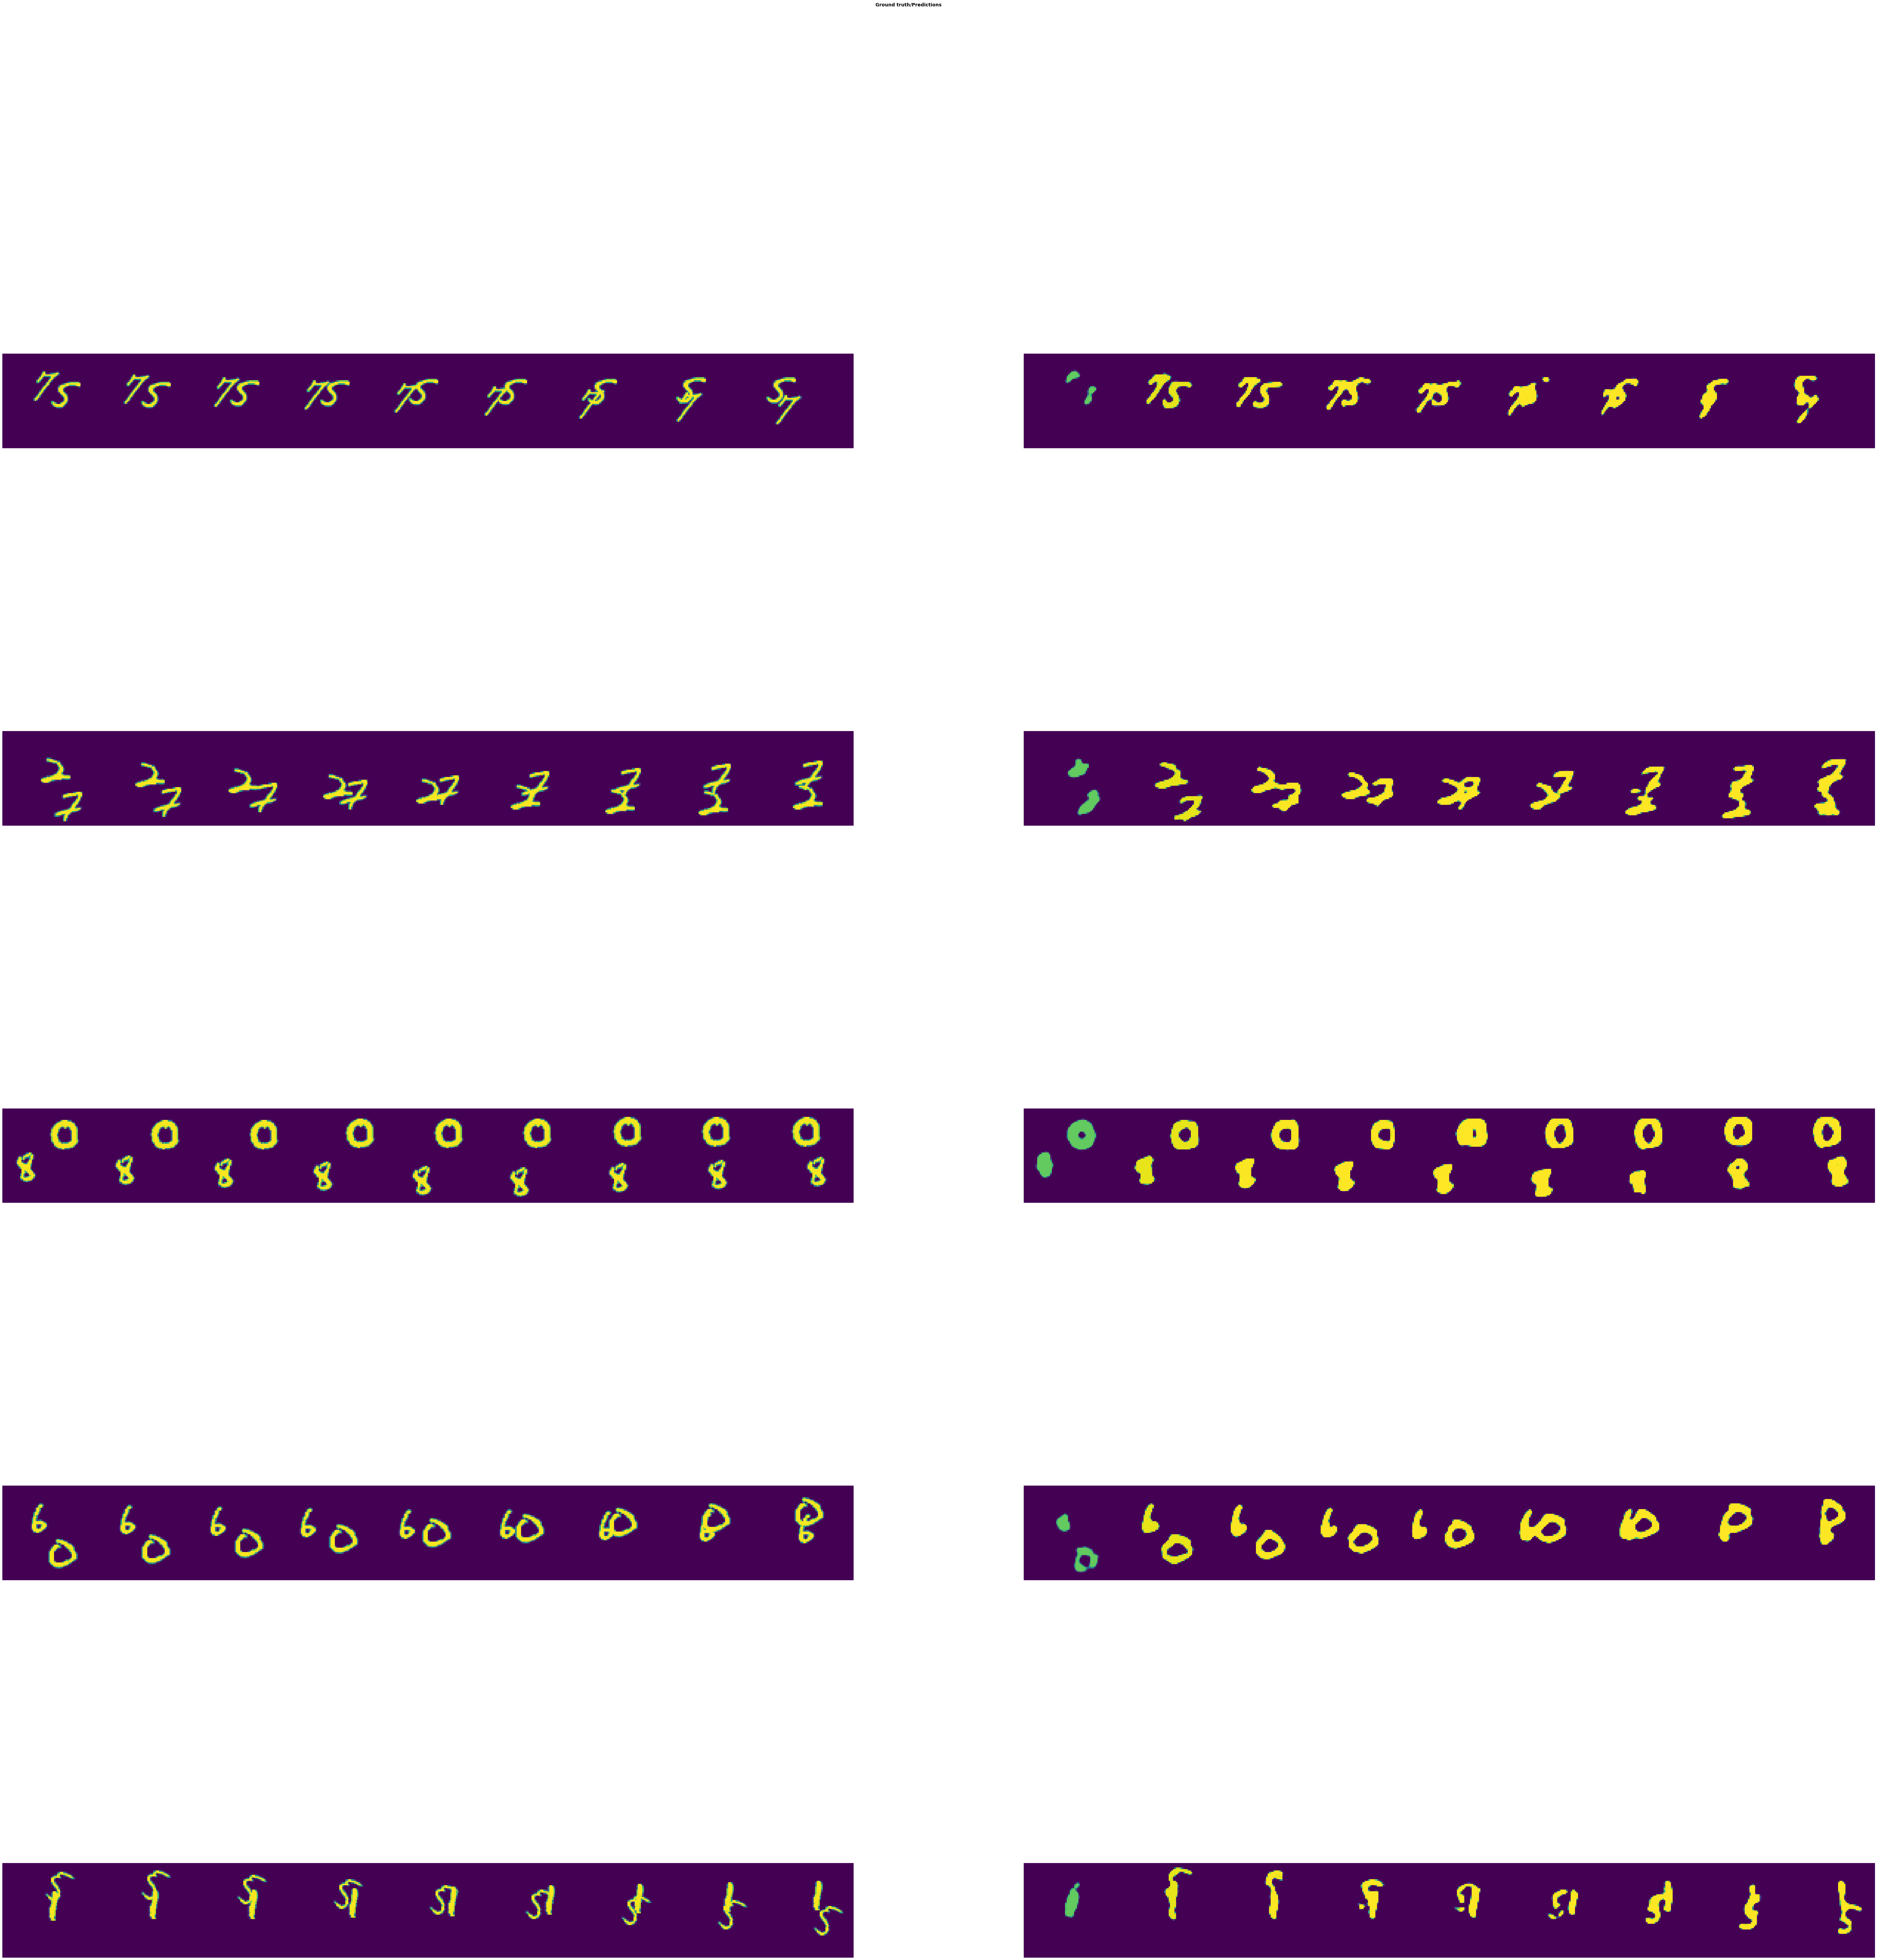

In [108]:
learner.show_results(figsize = (100, 100))

可以看出来预训练模型的效果还不错。。。起码趋势能够捕获到。